In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.auto import tqdm
import string
import warnings
warnings.filterwarnings('ignore')

# Substitution Cipher

In this task we will decrypt data that was scrambled using a Substitution Cipher. We assume that encryption key is unknown and we want to decrypt the data and read the code using recovered decryption key. [Introduction from here](http://statweb.stanford.edu/~cgates/PERSI/papers/MCMCRev.pdf) gives reference to the original task.

As verification we will take a piece from "Alice's adventures in Wonderland". We scramble data with a random encryption key, which we forgot after encrypting, and we would like to decrypt this encrypted text using MCMC Chains.

In [2]:
plain_text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'
So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!' (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before see a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge.
In another moment down went Alice after it, never once considering how in the world she was to get out again.
The rabbit-hole went straight on like a tunnel for some way, and then dipped suddenly down, so suddenly that Alice had not a moment to think about stopping herself before she found herself falling down a very deep well.
"""

We will use 26 letters of English alphabet.

In [3]:
characters = string.ascii_lowercase
characters_dict = {char : c for c, char in enumerate(characters, start=1)}
m = len(characters) + 1

In [4]:
print(characters_dict)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


## Generate random encryption key.

Here are functions that will be used to encrypt/decrypt text.

In [5]:
def encode_text(text_to_encode, characters_dict):
    """This function turns a text string into an integer sequence using given dictionary."""
    characters_set = set(characters_dict.keys())
    return np.r_[[characters_dict[char] if char in characters_set else 0 for char in text_to_encode.strip().lower()]]

def decode_text(text_to_decode, characters):
    """This function turns an integer sequence into a text string using given list of characters."""
    characters_array = np.array([" "] + list(characters))
    return "".join(characters_array[text_to_decode])

def apply_cipher(text_as_int_array, cipher):
    "This function applies substitution cipher to an integer sequence."
    return cipher[text_as_int_array]

Generate encryption and decryption keys. They are just permutations of the alphabet.

In [6]:
np.random.seed(1234)

encryption_indices = np.random.permutation(np.arange(m-1))
decryption_indices = np.argsort(encryption_indices)

characters_array = np.array(list(characters))
encryption_key = "".join(characters_array[encryption_indices])
decryption_key = "".join(characters_array[decryption_indices])
encryption_key, decryption_key

('hqcdbsfeainxkywoljrzumvgtp', 'iecdhgxajrmqvkpzbsfyuwolnt')

Check encoding/decoding functions and encryption/decryption keys.

In [7]:
encryption_key_encoded = np.r_[0, encode_text(encryption_key, characters_dict)]
decryption_key_encoded = np.r_[0, encode_text(decryption_key, characters_dict)]
encryption_key_encoded, decryption_key_encoded

(array([ 0,  8, 17,  3,  4,  2, 19,  6,  5,  1,  9, 14, 24, 11, 25, 23, 15,
        12, 10, 18, 26, 21, 13, 22,  7, 20, 16]),
 array([ 0,  9,  5,  3,  4,  8,  7, 24,  1, 10, 18, 13, 17, 22, 11, 16, 26,
         2, 19,  6, 25, 21, 23, 15, 12, 14, 20]))

In [8]:
text = "The quick brown fox jumps over the lazy dog"

encoded_text = encode_text(text, characters_dict)
cipher_text = apply_cipher(encoded_text, encryption_key_encoded)
encoded_text = apply_cipher(cipher_text, decryption_key_encoded)
encrypted_text = decode_text(cipher_text, characters_dict)
print(encrypted_text)
decrypted_text = decode_text(encoded_text, characters_dict)
print(decrypted_text)

zeb luacn qjwvy swg iukor wmbj zeb xhpt dwf
the quick brown fox jumps over the lazy dog


Encrypt cipher text.

In [9]:
plain_text_encoded = encode_text(plain_text, characters_dict)
cipher_text = apply_cipher(plain_text_encoded, encryption_key_encoded)
plain_text_encoded, cipher_text

(array([ 1, 12,  9, ..., 12, 12,  0]), array([ 8, 24,  1, ..., 24, 24,  0]))

## Collect frequences 

Collect frequences of two character combinations (bigrams) over large text corpus and from encrypted text. We will store them in a matrix and interpret it as a transition matrix: from the first character to the second.

In [10]:
def collect_transition_frequencies(data, transition_matrix):
    """For a given integer sequence, which corresponds to some char sequence, 
       return transitions for adjacent values."""
    transitions = data.repeat(2)[1:-1].reshape(-1, 2)
    for i, j in transitions:
        transition_matrix[i, j] += 1
    
    return transition_matrix

def collect_empirical_frequencies(filename, characters_dict, m):
    """Collect frequencies over large text corpus, return transition matrix."""
    transition_matrix = np.zeros((m, m))
    with open(filename) as f:
        for line in f:
            line_encoded = encode_text(line, characters_dict)
            if line_encoded.size > 1:
                transition_matrix = collect_transition_frequencies(line_encoded, transition_matrix)
                
    return transition_matrix

def collect_observed_frequencies(cipher_text, characters_dict, m):
    """Collect frequencies over encrypted text, return nonzero indices of 
       transition matrix for both dimensions and values for those indices.
       `values = transition_matrix[indices_1, indices_2]`"""
    transition_matrix = np.zeros((m, m))
    transition_matrix = collect_transition_frequencies(cipher_text, transition_matrix)
    
    return transition_matrix

Collect frequences.

In [11]:
empirical_frequencies = collect_empirical_frequencies('war_and_peace.txt', characters_dict, m)
observed_frequencies = collect_observed_frequencies(cipher_text, characters_dict, m)

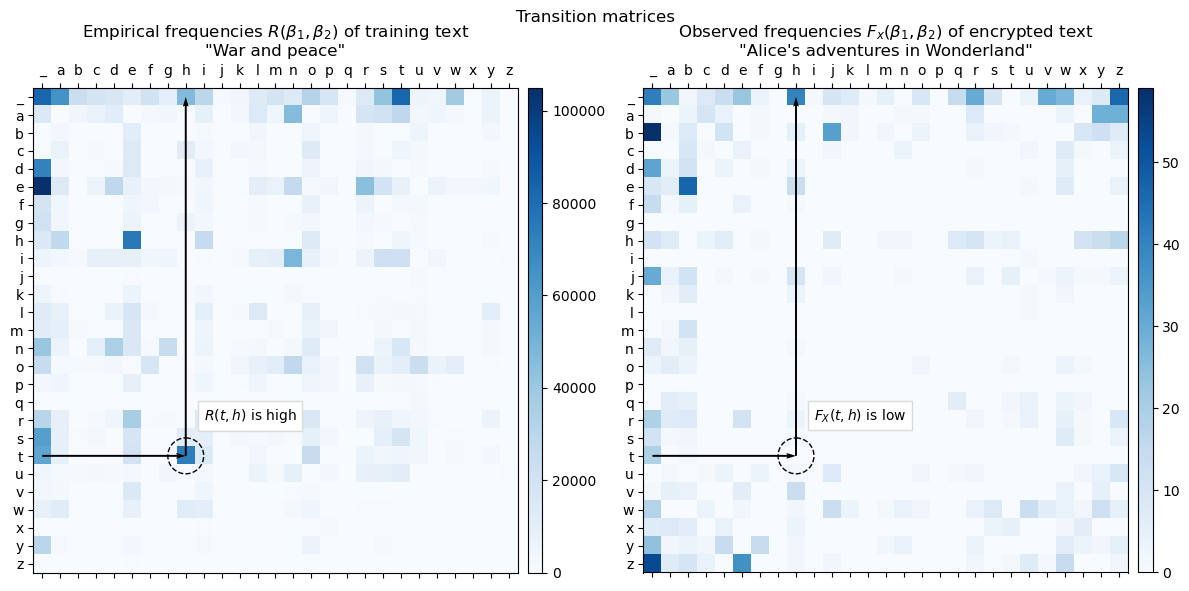

In [12]:
# Let's visualize the transition matrices
# https://matplotlib.org/stable/gallery/images_contours_and_fields/matshow.html#sphx-glr-gallery-images-contours-and-fields-matshow-py

fig = plt.figure(figsize=(12, 6))
(ax1, ax2) = fig.subplots(1, 2)

mat1 = ax1.matshow(empirical_frequencies, cmap='Blues')
ax1.set_xticks(list(range(27)))
ax1.set_xticklabels(['_'] + list(characters_dict.keys())) # '_' means any non-letter character
ax1.set_yticks(list(range(27)))
ax1.set_yticklabels(['_'] + list(characters_dict.keys()))
t_h1 = plt.Circle((8, 20), 1, color='black', fill=False, linestyle='--')
ax1.add_patch(t_h1)
ax1.quiver(0, 20, 8, 0, scale_units='xy', angles='xy', scale=1, color='black', width=0.004)
ax1.quiver(8, 20, 0, -20, scale_units='xy', angles='xy', scale=1, color='black', width=0.004)
ax1.text(9, 18, '$R(t, h)$ is high', fontsize=10, bbox=dict(facecolor='xkcd:white', edgecolor='xkcd:light grey'))
ax1.set_title('Empirical frequencies $R(\\beta_1,\\beta_2)$ of training text\n"War and peace"')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='3%', pad=0.1)
plt.colorbar(mat1, cax=cax1)

mat2 = ax2.matshow(observed_frequencies, cmap='Blues')
ax2.set_xticks(list(range(27)))
ax2.set_xticklabels(['_'] + list(characters_dict.keys()))
ax2.set_yticks(list(range(27)))
ax2.set_yticklabels(['_'] + list(characters_dict.keys()))
t_h2 = plt.Circle((8, 20), 1, color='black', fill=False, linestyle='--')
ax2.quiver(0, 20, 8, 0, scale_units='xy', angles='xy', scale=1, color='black', width=0.004)
ax2.quiver(8, 20, 0, -20, scale_units='xy', angles='xy', scale=1, color='black', width=0.004)
ax2.text(9, 18, '$F_X(t, h)$ is low', fontsize=10, bbox=dict(facecolor='xkcd:white', edgecolor='xkcd:light grey'))
ax2.add_patch(t_h2)
ax2.set_title('Observed frequencies $F_x(\\beta_1,\\beta_2)$ of encrypted text\n"Alice\'s adventures in Wonderland"')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="3%", pad=0.1)
plt.colorbar(mat2, cax=cax2)
plt.suptitle('Transition matrices')
plt.tight_layout()
plt.show();

## General algorithm

Our Chain will include states that are permutations of the substitution cipher. Algorithm has following steps:

1. Start by picking up a random current state. 
2. Create a proposal for a new state by swapping two or more random letters in the current state.
3. Use a Scoring Function which calculates the score of the current state $Score_{old}$ and the proposed state $Score_{new}$.
4. If the score of the proposed state is more than current state, Move to Proposed State.
5. Else flip a coin which has a probability of Heads $\frac{Score_{new}}{Score_{old}}$ . If it comes heads move to proposed State.
6. Repeat from Step 2.

We want ot reach a steady state where the chain has the stationary distribution of the needed states. This state of chain could be used as a solution.

Your goal is to implement steps 2 and 3 (see the templates below).

## Step 2: Prepare sampling function.

To generate a new proposed cipher we randomly select several positions and swap values at those positions. It corresponds to change in several mappings of encrypted characters in decrypted ones. Example with 2 swaps.

was|now
-|-
A -> B | A -> B
B -> C | B -> C
C -> D | C -> A
D -> A | D -> D

In [13]:
def generate_cipher(cipher, m, size=2):
    """Swap two or more random positions in cipher.
        
        cipher, np.array - current mapping from value(int) in encrypted text (index of array cell) into value(int) in decrypted text(value of array cell).
        m, int - capacity of used alphabet,
        size, int - number of positions to change.
    """
    
    # Your code here
    new_cipher = deepcopy(cipher)
    for i in range(size):
        # swap two elements at a time
        elem1, elem2 = np.random.choice(new_cipher, 2)
        new_cipher[elem1], new_cipher[elem2] = new_cipher[elem2], new_cipher[elem1]
    return new_cipher

In [14]:
# Test
generate_cipher(np.arange(m), m, 2)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 16, 13, 14, 18, 12,
       17, 15, 19, 20, 21, 22, 23, 24, 25, 26])

## Step 3: Prepare scoring function.

We want to use a scoring function for each state(Decryption key) which assigns a positive score to each decryption key. This score intuitively should be larger if the encrypted text looks more like actual english, when decrypted using this decryption key. We will check a large text and calculate frequencies: how many times one character comes after another in a large text like "War and Peace".

For each pair of characters $\beta_1$ and $\beta_2$ (e.g. $\beta_1$ = A and $\beta_2$ = B), we let $R(\beta_1,\beta_2)$ record the number of times that specific pair(e.g. "AB") appears consecutively in the reference text.

Similarly, for a considered decryption key $x$, we let $F_x(\beta_1,\beta_2)$ record the number of times that
pair appears when the cipher text is decrypted using the decryption key $x$.

We then Score a particular decryption key $x$ using:

$$Score(x) = \prod R(\beta_1,\beta_2)^{F_x(\beta_1,\beta_2)}$$
    
To make life easier with calculations we will calculate $log(Score(x))$

Now, you need to implement scoring function. As input it takes 
- `cipher`: mapping between encrypted characters and decrypted characters,
- `observed_frequences`: transition matrix for cipher text, matrix representation of $F_x(\beta_1,\beta_2)$,
- `empirical_frequences`: transition matrix for large text, matrix representation of $R(\beta_1,\beta_2)$.

Scoring function returns $log(Score(x))$. You need correctly process zero values in transition matrices while calculating the score.

In [15]:
def score_cipher(cipher, observed_frequencies, empirical_frequencies):
    
    # Your code here
    """Rule of log of product:
                       ___  F_x   __      F_x   __
    log Score(x) = log | | R    = >_ log R    = >_ F_x log R
    """

    R = empirical_frequencies
    # Try to decode, using cipher as the decryption key
    decryption_key_encoded = cipher
    encoded_text = apply_cipher(cipher_text, decryption_key_encoded)
    # Obtain F_x
    observed_frequencies = collect_observed_frequencies(encoded_text, characters_dict, m)
    F_cipher = observed_frequencies
    # Score the cipher
    # since log 0 -> -inf, substitute all values R equal to 0 with 0
    score = np.sum(F_cipher * np.log(R, out=np.zeros_like(R), where=(R != 0)))
    #print(score)
    return score

## Decryption

Now we are ready to decrypt cipher text.

In [16]:
def colorize_text(test_text, true_text, color_code):
    """Compare test_text against true_text character by character,
        and return the test_text with not equal characters (mistakes) marked with red color.
        test_text, str - some test text
        true_text, str - true text to compare against
    """
    colorized_text = ''
    for i in range(len(true_text)):
        if test_text[i] != true_text[i]:
            colorized_text += f'\033[{color_code}m' + test_text[i] + '\033[0m'
        else: colorized_text += test_text[i]
    return colorized_text

In [17]:
true_text = ' '.join(decode_text(encode_text(plain_text, characters_dict), characters).split())[0:111]

In [18]:
def decrypting(observed_frequencies, empirical_frequencies, n_iters, m, step_size, seed, print_it=1000):
    """This function finds most suited decrypting cipher(1D np.array).
        observed_frequencies, 2D np.array - transition matrix with frequencies for cipher text,
        empirical_frequencies, 2D np.array - transition matrix with frequencies for large text,
        n_iters, int - number of MCMC iterations,
        step_size, int - number of changes in cipher per one iteration,
        seed, int - seed for random generator,
        print_it, int - print decrypted text every `print_it` iterations.
    """

    np.random.seed(seed)

    # 1. Start by picking up a random current state. 
    cipher_old = np.arange(m)
    
    score_cipher_old = score_cipher(cipher_old, observed_frequencies, empirical_frequencies)
    best_state, score = cipher_old, score_cipher_old

    for i in tqdm(range(1, n_iters+1)):

        # 2. Create a proposal for a new state by swapping two or more random letters in the current state.
        cipher_new = generate_cipher(cipher_old, m, size=step_size)

        # 3. Use a Scoring Function which calculates the score of the current state $Score_{old}$ and the proposed State $Score_{new}$.
        score_cipher_new = score_cipher(cipher_new, observed_frequencies, empirical_frequencies)
        acceptance_probability = np.min((1, np.exp(score_cipher_new - score_cipher_old)))

        # 4. If the score of the proposed state is more than current state, Move to Proposed State.
        # 5. Else flip a coin which has a probability of Heads $Score_{new}/Score_{old}$. If it comes heads move to proposed State.
        if score_cipher_old > score:
            best_state, score = cipher_old, score_cipher_old
        if acceptance_probability > np.random.uniform(0,1):
            cipher_old, score_cipher_old = cipher_new, score_cipher_new
        if i % print_it == 0:
            decoded_text = ' '.join(decode_text(apply_cipher(cipher_text, cipher_old), characters).split())[0:111]
            print(f"iter {i}: {colorize_text(decoded_text, true_text, '31')}")

    #print('Best state:', best_state)
    return best_state

In [19]:
decrypt_cipher = decrypting(observed_frequencies, empirical_frequencies, 1100, m, 1, 345, 100)
decoded_text = ' '.join(decode_text(apply_cipher(cipher_text, decrypt_cipher), characters).split())
markers = ''
for word in true_text.split():
    n = len(word)
    marker = [' '] * n
    marker[int(n/2)] = '|'
    markers += ''.join(marker) + ' '
print(
    f"\nDecoded Text: {colorize_text(decoded_text, true_text, '31')}\n"
    f"              {markers}\n"
    f"True Text:    {true_text}\n\n"
    f"MCMC KEY  : {colorize_text(' '.join(characters_array[decrypt_cipher[1:]-1]), ' '.join([char for char in decryption_key]), '31')}\n"
    
    f"Actual KEY: {' '.join([char for char in decryption_key])}"
)

  0%|          | 0/1100 [00:00<?, ?it/s]

iter 100: opahe som zefallalf cy fec keit caied yb maccalf zt rei mamcei yl cre zoln old yb rokalf lycralf cy dy ylhe yi 
iter 200: olare bof wepassasp tn pet vemy tamed ni fattasp wy hem faftem ns the wosc osd ni hovasp snthasp tn dn nsre nm 
iter 300: olame wof beparrarp tn pet vesy tased ni fattarp by hes faftes nr the bork ord ni hovarp rntharp tn dn nrme ns 
iter 400: alope was bemorrorm ti met veny toned if sottorm by hen sosten ir the bark ard if havorm rithorm ti di irpe in 
iter 500: alipe was bemirrirm to met veny tined of sittirm by hen sisten or the bark ard of havirm rothirm to do orpe on 
iter 600: alice was beminninm to met very tired of sittinm by her sister on the bank and of havinm nothinm to do once or 
iter 700: alice was beminninm to met very tired of sittinm by her sister on the bank and of havinm nothinm to do once or 
iter 800: alice was beminninm to met very tired of sittinm by her sister on the bank and of havinm nothinm to do once or 
iter 900: alice was begi

# Discussion

In [20]:
# Characters 'x' and 'z' are absent in the test text 
'x' in plain_text, 'z' in plain_text

(False, False)

We can see that the algorithm works, and we were able to decrypt the test text in just around $1000$ iterations.
Is is also seen, that not all characters in the decryption key MCMC were restored: characters ```x``` and ```z``` are swapped.
This is expected, since both characters and their bigrams ```x*```, ```*x```, ```z*```, ```*z``` are absent in the test text.
So, observed frequencies $F_x($ ```x```, ```*``` $) = F_x($ ```*```, ```x``` $) = F_x($ ```z```, ```*``` $) = F_x($ ```*```, ```z``` $) = 0$, and thus they do not contribute into the $Score(x)$,
which means, that none of those equal scores, which include these four frequencies in the calculation, have any preference over each other, and so cannot improve the predictions. By pure chance, for example with other random choices and seeds, ```x``` and ```z``` could be in the right place in the MCMC key.
Anyway, it's not a problem for this text -- it can be safely decrypted without these unused two characters and their bigrams.